In [36]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F


import os
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage.io as io
from skimage.transform import resize

import tensorflow as tf
from tfrecord.torch.dataset import TFRecordDataset

In [37]:
# hyperparams
batch_size = 50

# Write TFrecord files

In [38]:
saves_folders = "../../../rl_data"
load_paths = [os.path.join(saves_folders, saves_folder) for saves_folder in os.listdir(saves_folders)]

In [39]:
load_path = "../../../rl_data/saves_1"
save_path = "../../../rl_data/tfrecord"

In [5]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, image_shape):
    feature = {
        'image': _bytes_feature(image),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [6]:
DI_SHAPE = (270, 480, 1)
nb_files = int(len([f for f in os.listdir(load_path) if f.endswith('.p') and os.path.isfile(os.path.join(load_path, f))]) / 5) # five dicts
print("NUMBER OF PICKLE STACKS", nb_files)
# for k in range(nb_files):
#     obs_load          = pickle.load(open( load_path + "/obs_dump" +str(k) + ".p", "rb"))
#     di_load           = pickle.load(open( load_path + "/di_dump" + str(k) + ".p", "rb"))
#     action_load       = pickle.load(open( load_path + "/action_dump" + str(k) + ".p", "rb"))
#     action_index_load = pickle.load(open( load_path + "/action_index_dump" + str(k) + ".p", "rb"))
#     collision_load    = pickle.load(open( load_path + "/collision_dump" + str(k) + ".p", "rb"))

#     filename = save_path + '/data' + str(k) + '.tfrecords'
#     N_episode = len(di_load)

#     with tf.io.TFRecordWriter(filename) as writer:
#         for i in range(N_episode):
#             di_episode = di_load[i]
#             N_images = len(di_episode)

#             N_sample_append = 0
#             is_first_collide_idx = False
#             for j in range(N_images):
#                 di_current = di_episode[j]

#                 example = serialize_example(tf.io.serialize_tensor(di_current), DI_SHAPE)
#                 writer.write(example)

#                 # augment horizontally flip data
#                 # io.imshow(di_current[...,0] / 255)
#                 # io.show()
#                 di_flip = np.flip(di_current, 1)

#                 # io.imshow(di_flip[...,0] / 255)
#                 # io.show()

#                 # flip the omega_z # TODO what about other states?
#                 example_flip = serialize_example(tf.io.serialize_tensor(di_flip), DI_SHAPE)
#                 writer.write(example_flip)   


NUMBER OF PICKLE STACKS 200


# Read TFrecord Files

In [70]:
tfrecord_path = "../../../rl_data/tfrecord"
tf_files = os.listdir(tfrecord_path)
tf_files_full = [os.path.join(tfrecord_path, file) for file in tf_files]

In [71]:
raw_dataset = tf.data.TFRecordDataset(tf_files_full)
raw_dataset


<TFRecordDatasetV2 shapes: (), types: tf.string>

In [72]:
for raw_record in raw_dataset.take(1):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xa0\xf5\x07\n\x0e\n\x05depth\x12\x05\x1a\x03\n\x01\x01\n\xe9\xf4\x07\n\x05image\x12\xde\xf4\x07\n\xda\xf4\x07\n\xd6\xf4\x07\x08\x04\x12\x0e\x12\x03\x08\x8e\x02\x12\x03\x08\xe0\x03\x12\x02\x08\x01"\xc0\xf4\x07\xba\xba\xbb\xbb\xbb\xbc\xbc\xbc\xbd\xbd\xbd\xbe\xbe\xbf\xbf\xbf\xc0\xc0\xc0\xc1\xc1\xc1\xc2\xc2\xc3\xc3\xc3\xc4\xc4\xc5\xc5\xc5\xc6\xc6\xc6\xc7\xc7\xc8\xc8\xc8\xc9\xc9\xca\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\

2022-02-23 16:22:32.697940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-23 16:22:32.717176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


In [73]:
tfrecord_path = tf_files_full[0]
index_path = None
import cv2

description = {
    "image": "byte", 
    "height": "int",
    "width": "int",
    "depth": "int"
}

def decode_image(features):
    # get BGR image from bytes
    features["image"] = cv2.imdecode(features["image"], -1)
    return features

dataset = TFRecordDataset(tfrecord_path, index_path=None, description=description)
loader = torch.utils.data.DataLoader(dataset, batch_size=32)

data = next(iter(loader))
for i in range(32):
    print(data["image"][i].shape)

torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])
torch.Size([129622])


/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py:64: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return default_collate([torch.as_tensor(b) for b in batch])


# Depth Image Dataset

In [42]:
load_path = "../../../rl_data/saves_1"

In [63]:
class DepthImageDataset(Dataset):
    def __init__(self, load_path=load_path) -> None:
        super(DepthImageDataset, self).__init__()
        
        self.x = torch.empty(0)
        self.nb_images = 0
        self.nb_files = int(len([f for f in os.listdir(load_path) if f.endswith('.p') and os.path.isfile(os.path.join(load_path, f))]) / 5) # five dicts
        print(f"Loading from {load_path}")
        for i in tqdm(range(1)):
            di_load           = pickle.load(open(load_path + "/di_dump" + str(i) + ".p", "rb"))
            
            x_ = []
            for ep in di_load.values():
                for image in ep:
                    image = image / 256
                    image = image.transpose(2, 0, 1)
                    image = np.pad(image, [(0,0), (1, 1), (0, 0)], mode='constant', constant_values=0)
                    image_flipped = np.flip(image, 2)
                    x_.append(image)
                    x_.append(image_flipped)

                    self.nb_images += 2

            self.x = torch.cat((self.x, torch.Tensor(np.array(x_))))
    
    def __getitem__(self, index: int):
        return self.x[index]
    
    def __len__(self):
        return self.nb_images
    
data = DepthImageDataset()
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=False, num_workers=0)

Loading from ../../../rl_data/saves_1


100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


In [64]:
len(data), len(data_loader)

(2326, 47)

torch.Size([50, 1, 272, 480])
torch.Size([1, 272, 480])


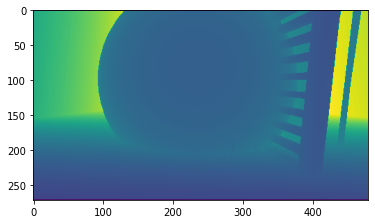

In [65]:
dataiter = iter(data_loader)
images = dataiter.next()
print(images.shape)

image = images[2]
print(image.shape)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(image)

In [66]:
images.mean()

tensor(0.4118)